In [1]:
import numpy as np
import pandas as pd
import os, json, time, sys, re, glob
import requests
import csv
import io
from pathlib import Path
import matplotlib.pyplot as plt
import random


# Βιβλιοθήκες για ενεργοποίηση της κάρτας γραφικών
# Πρέπει προηγουμένως να έχει γίνει εγκατάσταση του tensorflow και αν χρησιμοποιηθεί Gpu θα πρεπει να γίνει
# εγκατάσταση της CUDA.
import tensorflow
print("tensorflow version: ",tensorflow.version.VERSION)
print("\nNum GPUs Available: ", len(tensorflow.config.experimental.list_physical_devices('GPU')))

gpus = tensorflow.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tensorflow.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tensorflow.config.experimental.list_logical_devices('GPU')

print("Gpus: ",gpus)

# Εισαγωγή βιβλιοθκών για deep learning με χρήση του keras μεσω tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM, SimpleRNN, Bidirectional, TimeDistributed
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Masking
from tensorflow.keras.layers import Embedding, MaxPool1D
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.layers import Bidirectional, BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.initializers import glorot_uniform, RandomUniform, lecun_uniform, Constant
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import OrderedDict
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
from transformers import TFBertModel
from transformers import BertTokenizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TFAutoModelForSequenceClassification
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D, GlobalMaxPool1D

# Εισαγωγή βιβλιοθηκών για χρήση word2vec
# Πρέπει να έχει προηγθεί εγκατάσταση της βιβλιοθήκης gensim (pip install gensim)
import gensim
from gensim import downloader as api
from gensim.models import Word2Vec#Loading the models/ embedding vector using KeyedVectors.load function from gensim
from sklearn.manifold import TSNE


tensorflow version:  2.6.0

Num GPUs Available:  1
Gpus:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


c:\Users\bamdi\anaconda3\envs\tf_codebert\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# define seeder
seed = 123
np.random.seed(seed)
tensorflow.random.set_seed(seed) # χρήσιμη για όσο το δυνατόν πιο σταθερά αποτελέσματα σε κα΄θε επανάληψης της διαδικασίας εκπαίδευσης και εκτέλεσης του μοντέλου


In [3]:
# shuffle the files from the beginning
def readFiles(inputPath):
    suffix1 = ".java"
    pathlist = []
    
    for root, dirs, files in os.walk(inputPath):
        for file in files:
            if (file.endswith(suffix1)):
                root2 = Path(root)
                pathlist.append(root2 / file)                 
    return pathlist

def createPathlist(inputlist, finallist):
    for i in range(len(inputlist)):
        finallist.append(inputlist[i])
    return finallist

labels = []
paths = []


inputPaths = [
    os.getcwd() + "\Dataset\JAVA_snippets\Exceptions",
    os.getcwd() + "\Dataset\JAVA_snippets\File_Handling",
    os.getcwd() + "\Dataset\JAVA_snippets\GUI",
    os.getcwd() + "\Dataset\JAVA_snippets\JDBC",
    os.getcwd() + "\\Dataset\\JAVA_snippets\\Unit_Testing",
    os.getcwd() + "\Dataset\JAVA_snippets\Others"
    
]

all_files_path = []
for inputPath in inputPaths:
    files_path = readFiles(inputPath)
    all_files_path.extend(files_path)
# shuffle the paths
random.shuffle(all_files_path)


for path in all_files_path: 
    if 'Exceptions' in str(path):
        labels.append(0)
    if 'File_Handling' in str(path):
        labels.append(1)
    if 'GUI' in str(path):
        labels.append(2)
    if 'JDBC' in str(path):
        labels.append(3)
    if 'Unit_Testing' in str(path):
        labels.append(4)
    if 'Others' in str(path):
        labels.append(5)

print(labels)
print(len(all_files_path))
print(len(labels))

[0, 1, 0, 3, 0, 1, 4, 0, 2, 2, 2, 3, 2, 0, 4, 4, 3, 4, 4, 1, 5, 0, 2, 3, 2, 2, 2, 0, 3, 2, 1, 5, 5, 4, 2, 2, 0, 2, 0, 5, 0, 3, 4, 2, 1, 3, 2, 0, 5, 3, 1, 2, 4, 4, 0, 3, 0, 2, 1, 3, 3, 5, 4, 3, 4, 4, 5, 3, 3, 4, 3, 5, 2, 1, 1, 2, 3, 0, 1, 4, 5, 4, 2, 2, 1, 5, 0, 0, 4, 5, 1, 1, 4, 1, 1, 1, 3, 1, 2, 0, 3, 2, 0, 5, 0, 4, 3, 2, 3, 1, 4, 2, 5, 2, 1, 1, 2, 5, 2, 0, 0, 5, 0, 0, 2, 0, 5, 1, 0, 5, 5, 4, 0, 3, 1, 3, 4, 1, 4, 2, 1, 1, 1, 5, 0, 0, 2, 5, 0, 3, 2, 4, 3, 4, 2, 4, 4, 0, 5, 4, 3, 0, 4, 5, 5, 1, 2, 3, 0, 3, 4, 2, 1, 3, 3, 1, 2, 4, 3, 3, 2, 4, 1]
183
183


In [4]:
# Συναρτήσεις χρήσιμες για custom tokenization του πηγαίου κώδικα
def listToString(s): 
    
    # initialize an empty string
    str1 = "" 
    
    # traverse in the string  
    for ele in s: 
        str1 += ele  
    
    # return string  
    return str1 

def stringToList(string):
    codeLinesList = []
    for line in string.splitlines():
        codeLinesList.append(line)
    return codeLinesList

def createListOfTokens(codeFilename):
    """
    Given a file name in the current working directory, read each line 
    and append it to a list.
    Return: the contents of the file as a list of strings
    """
    codeLinesList = []

    #with open(codeFilename, "r", encoding='utf-8', errors='ignore') as fin:
    #with open(path, 'rb') as f:
    with open(codeFilename, "r", encoding='utf-8', errors='ignore') as fin:
        for line in fin:
            codeLinesList.append(line)

    return codeLinesList

In [5]:
# Συνάρτησ για αφαίρεση των σχολίων
def remove_comments(content, language):
    if language == "cpp":
        def gen_content():
            block_comment = False
            line_comment = False
            probably_a_comment = False
            for character in content:
                if not line_comment and not block_comment and character == '/':
                    probably_a_comment = True
                    continue
    
                if block_comment and character == '*':
                    probably_a_comment = True
                    continue
    
                if line_comment and character == '\n':
                    line_comment = False
                    yield '\n'
                elif block_comment and probably_a_comment and character == '/':
                    block_comment = False
                elif not line_comment and not block_comment:
                    if probably_a_comment:
                        if character == '/':
                            line_comment = True
                        elif character == '*':
                            block_comment = True
                        else:
                            yield '/'
                            yield character
                    else:
                        yield character
                probably_a_comment = False
    
        return ''.join(gen_content())
    
    elif language == "java" or language == "javascript":
        commentsPattern = re.compile("(//.*?$)|(/\\*.*?\\*/)", flags=re.MULTILINE|re.DOTALL )
        stringsPattern = re.compile("(\".*?(?<!\\\\)\")")
             
        commentMatches = [ ]
        commentsToRemove = [ ]
         
        cmatcher = re.finditer( commentsPattern, content )
        smatcher = re.finditer( stringsPattern, content )
         
        for cm in cmatcher:
            commentMatches.append( cm )
            
        for sm in smatcher:
            for cm in commentMatches:
                if cm.start() > sm.start() and cm.start()<sm.end():
                    commentsToRemove.append( cm )
         
        for cm in commentsToRemove:
            commentMatches.remove( cm )
         
        for cm in commentMatches:
            content = content.replace( cm.group()," " )
        
        return content
    
#remove headers/import statements

def dropBlank(tokens0):
    tokens = []
    for i in range(0, len(tokens0)):
        temp = tokens0[i]
        if temp != '':
            tokens.append(temp)
    return tokens

def tokenizeLines(codeLinesList):
    """
    Tokenize each file line, i.e. entry of code list, based on a specified
    regex.
    ***The regex used is not applicable to every case. One needs to configure
    it based on file inputs.

    Return: list containing code tokens
    """
    #enalaktika codeLinesList.split() gia na meinoun ta tokens mazi me to punctuation
    codeTokens = []

    for line in codeLinesList:
        templineTokens = re.split('[\.,\[\];:(\s)?\\\\!\t{}"<>+=~*&^%/|\\-\']', line)
        codeTokens.extend(templineTokens)
    return codeTokens

def getLengths(data):
    lens = []
    for i in range(len(data)):
        lens.append(len(data[i]))
    lens = pd.DataFrame(lens)
    return lens

In [6]:
# Για κάθε αρχείο δημιουργούμε tokens, αντικαθιστούμε numbers, String και chars με συγκεκριμένα Ids και έπειτα 
# δημιουργούμε μία λίστα από λίστες που περιέχουν: (1) όνομα αρχείου (2) class label (3) τις ακολουθίες tokens (λέξεων)
def fill_labels(paths, labels):
    allTokens = []
    indices = []
    for i in range(0, len(paths)):
        path = paths[i]
        label = labels[i]      
        
        #add the label info
        if (label == 0):
            indices.append(0)
        elif (label == 1):
            indices.append(1)
        elif (label == 2):
            indices.append(2)
        elif (label == 3):
            indices.append(3)
        elif (label == 4):
            indices.append(4)
        elif (label == 5):
            indices.append(5)
        
    return indices

indices = fill_labels(all_files_path, labels)
print(indices)


[0, 1, 0, 3, 0, 1, 4, 0, 2, 2, 2, 3, 2, 0, 4, 4, 3, 4, 4, 1, 5, 0, 2, 3, 2, 2, 2, 0, 3, 2, 1, 5, 5, 4, 2, 2, 0, 2, 0, 5, 0, 3, 4, 2, 1, 3, 2, 0, 5, 3, 1, 2, 4, 4, 0, 3, 0, 2, 1, 3, 3, 5, 4, 3, 4, 4, 5, 3, 3, 4, 3, 5, 2, 1, 1, 2, 3, 0, 1, 4, 5, 4, 2, 2, 1, 5, 0, 0, 4, 5, 1, 1, 4, 1, 1, 1, 3, 1, 2, 0, 3, 2, 0, 5, 0, 4, 3, 2, 3, 1, 4, 2, 5, 2, 1, 1, 2, 5, 2, 0, 0, 5, 0, 0, 2, 0, 5, 1, 0, 5, 5, 4, 0, 3, 1, 3, 4, 1, 4, 2, 1, 1, 1, 5, 0, 0, 2, 5, 0, 3, 2, 4, 3, 4, 2, 4, 4, 0, 5, 4, 3, 0, 4, 5, 5, 1, 2, 3, 0, 3, 4, 2, 1, 3, 3, 1, 2, 4, 3, 3, 2, 4, 1]


In [7]:
def fill_text_list(paths, labels):
    allTokens = []
    indices = []
    text = []
    for i in range(0, len(paths)):
        path = paths[i]
        label = labels[i]
        
        #tokenize source code in a list of lines
        lines0 = createListOfTokens(path)
        
        #convert source code from list of lines to string
        stringLines = listToString(lines0)
        
        stringLinesNoDigit = re.sub(r"$\d+\W+|\b\d+\b|\W+\d+$", "<numId$>", stringLines) #replace numbers 
        
        stringLinesNoStr = re.sub(r'(["])(?:(?=(\\?))\2.)*?\1', "<strId$>", stringLinesNoDigit) #replace strings
        
        stringLinesNoChar = re.sub(r"(['])(?:(?=(\\?))\2.)*?\1", "<strId$>", stringLinesNoStr) #replace chars
        
        #remove comments from source code if wanted 
        if label < 7:
            lang = "java"       
        linesNoCom = remove_comments(stringLinesNoChar, lang)
        
        
        
        
        text.append(linesNoCom)
    return text

alltext = fill_text_list(all_files_path, labels)

# print(alltext[0])


class FourException extends Exception {}

public class AlwaysFinally {
  public static void main(String[] args) {
    System.out.println(<strId$>);
    try {
      System.out.println(<strId$>);
      try {
        throw new FourException();
      } finally {
        System.out.println(<strId$>);
      }
    } catch(FourException e) {
      System.out.println(
        <strId$>);
    } finally {
      System.out.println(<strId$>);
    }
  }
}

183


In [8]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
inputs = tokenizer(alltext, padding=True, truncation=True, return_tensors='tf') 
dataset=tensorflow.data.Dataset.from_tensor_slices((dict(inputs), indices)) 

AUTOTUNE = tensorflow.data.experimental.AUTOTUNE

#shuffled_ds = dataset.shuffle(buffer_size=len(paths)).batch(1)
#print(inputs)
#encoded_sequences = tokenizer(sequences, padding=True, truncation=True, return_tensors='tf')

183


In [9]:
for element in dataset.as_numpy_iterator():
    print(element[1])

4
4
0
3
3
5
5
3
2
0
3
3
3
5
5
0
5
0
0
1
4
4
0
1
2
0
5
2
0
2
1
0
3
0
4
4
5
4
4
5
5
5
3
0
5
1
2
0
3
2
1
0
4
3
0
1
2
1
3
2
4
3
5
0
1
2
2
0
0
4
2
4
4
2
1
4
1
4
1
5
4
1
2
5
3
5
0
2
4
4
2
2
0
1
3
3
2
3
2
4
4
3
3
2
0
3
1
3
4
2
1
2
1
3
4
2
3
3
2
1
0
2
1
4
0
4
2
2
1
2
2
5
4
1
3
3
3
2
0
1
2
2
4
1
3
0
1
4
0
0
0
0
1
4
5
0
3
2
2
1
5
5
2
5
1
1
2
4
1
4
3
0
5
4
3
1
5
0
1
0
2
3
5


In [10]:
# Split the dataset into train, validation, and test sets
train_size = int(0.7 * len(all_files_path))
val_size = int(0.3 * len(all_files_path))
test_size = len(all_files_path) - train_size - val_size

AUTOTUNE = tensorflow.data.experimental.AUTOTUNE
batch_size = 1
val_ds=dataset.take(val_size).batch(batch_size, drop_remainder=True) 
train_ds=dataset.skip(val_size).batch(batch_size, drop_remainder=True)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = dataset.take(test_size).batch(batch_size, drop_remainder=True)

In [11]:
# από εδώ παίρνω τα labels του σετ που θέλω
val_indices = []
for element in val_ds.as_numpy_iterator():
    print(element[1])
    val_indices.append((element[1]))
val_indices
len(val_indices)


[4]
[4]
[0]
[3]
[3]
[5]
[5]
[3]
[2]
[0]
[3]
[3]
[3]
[5]
[5]
[0]
[5]
[0]
[0]
[1]
[4]
[4]
[0]
[1]
[2]
[0]
[5]
[2]
[0]
[2]
[1]
[0]
[3]
[0]
[4]
[4]
[5]
[4]
[4]
[5]
[5]
[5]
[3]
[0]
[5]
[1]
[2]
[0]
[3]
[2]
[1]
[0]
[4]
[3]


54

In [13]:
# Define and compile the model

model = TFAutoModelForSequenceClassification.from_pretrained("microsoft/codebert-base", num_labels=6)
model.compile(
    optimizer=tensorflow.keras.optimizers.Adam(learning_rate=1e-5, clipnorm=1.),
    loss=tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tensorflow.keras.metrics.SparseCategoricalAccuracy(), 
             tensorflow.keras.metrics.SparseTopKCategoricalAccuracy(k=2, name='Top_2_Categorical_Accuracy')]
)

history = model.fit(train_ds, validation_data=val_ds, epochs=3, verbose=1)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
129/129 [==============================] - 55s 323ms/step - loss: 1.7276 - sparse_categorical_accuracy: 0.2403 - Top_2_Categorical_Accuracy: 0.4574 - val_loss: 1.6516 - val_sparse_categorical_accuracy: 0.2778 - val_Top_2_Categorical_Accuracy: 0.4444
Epoch 2/3
129/129 [==============================] - 37s 287ms/step - loss: 1.2773 - sparse_categorical_accuracy: 0.5814 - Top_2_Categorical_Accuracy: 0.7364 - val_loss: 1.2700 - val_sparse_categorical_accuracy: 0.5741 - val_Top_2_Categorical_Accuracy: 0.7407
Epoch 3/3
129/129 [==============================] - 37s 287ms/step - loss: 0.6652 - sparse_categorical_accuracy: 0.8372 - Top_2_Categorical_Accuracy: 0.9457 - val_loss: 0.7601 - val_sparse_categorical_accuracy: 0.7593 - val_Top_2_Categorical_Accuracy: 0.8889


In [14]:
model.save_weights('./saved_weights.h5')

In [15]:
test_ds = dataset.take(test_size).batch(batch_size, drop_remainder=True)
model.evaluate(test_ds)

1/1 [==============================] - 0s 231ms/step - loss: 1.9837 - sparse_categorical_accuracy: 0.0000e+00 - Top_2_Categorical_Accuracy: 0.0000e+00


[1.9837112426757812, 0.0, 0.0]

In [16]:
logits=model.predict(val_ds, verbose=1).logits
prob=tensorflow.nn.softmax(logits, axis=1).numpy()
predictions=np.argmax(prob, axis=1)

#confusion_matrix=tensorflow.math.confusion_matrix(val_indices, predictions, num_classes=6)

54/54 [==============================] - 4s 58ms/step


In [17]:
import sklearn.metrics as metrics
precision=metrics.precision_score(val_indices, predictions, average='weighted')
recall=metrics.recall_score(val_indices, predictions, average='weighted')
f1=metrics.f1_score(val_indices, predictions, average='weighted')
print('Precision:{}, Recall:{}, F1 score:{}.'.format(precision, recall, f1))

Precision:0.8747456247456248, Recall:0.7592592592592593, F1 score:0.7408032188733942.


In [18]:
predictions

array([0, 5, 4, 5, 2, 2, 4, 3, 0, 3, 0, 2, 1, 5, 2, 1, 5, 0, 1, 3, 5, 4,
       2, 1, 2, 2, 1, 3, 3, 4, 4, 0, 2, 3, 4, 2, 1, 0, 4, 5, 3, 4, 1, 3,
       0, 1, 3, 4, 2, 2, 1, 3, 5, 0], dtype=int64)

In [18]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Create the confusion matrix
cm = confusion_matrix(val_indices, predictions)

# Extract values from the confusion matrix
true_positives = np.diag(cm)
false_positives = np.sum(cm, axis=0) - true_positives
false_negatives = np.sum(cm, axis=1) - true_positives
true_negatives = np.sum(cm) - (true_positives + false_positives + false_negatives)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Print the matrix with true positives, false positives, false negatives, and true negatives
print("\nMatrix:")
print("True Positives:", true_positives)
print("False Positives:", false_positives)
print("False Negatives:", false_negatives)
print("True Negatives:", true_negatives)

Confusion Matrix:
[[ 3  9  0  0  0  1]
 [ 0  5  0  0  0  0]
 [ 0  0  6  0  0  0]
 [ 0  0  1  9  0  0]
 [ 0  0  0  1  7  1]
 [ 0  0  0  0  0 11]]

Matrix:
True Positives: [ 3  5  6  9  7 11]
False Positives: [0 9 1 1 0 2]
False Negatives: [10  0  0  1  2  0]
True Negatives: [41 40 47 43 45 41]


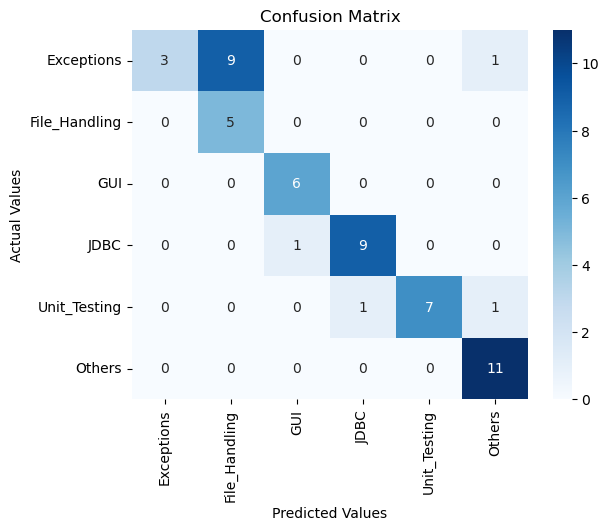

In [19]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt

# Create the confusion matrix
cm = confusion_matrix(val_indices, predictions)

# Set labels for the x-axis and y-axis
labels = ['Exceptions', 'File_Handling', 'GUI', 'JDBC', 'Unit_Testing', 'Others']

# Plot the confusion matrix using seaborn
sn.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

# Set the title, x-axis label, and y-axis label
plt.title('Confusion Matrix')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Display the plot
plt.show()

In [20]:
shpred = predictions
random.shuffle(shpred)
list = [shpred[0], shpred[1], shpred[2], shpred[3], shpred[4], shpred[5]]
list

[5, 5, 5, 4, 2, 5]

In [21]:
# Evaluate the model on the test set
test_ds = dataset.skip(train_size + val_size).batch(batch_size)
results = model.evaluate(test_ds)

1/1 [==============================] - 2s 2s/step - loss: 0.5589 - sparse_categorical_accuracy: 1.0000 - Top_2_Categorical_Accuracy: 1.0000


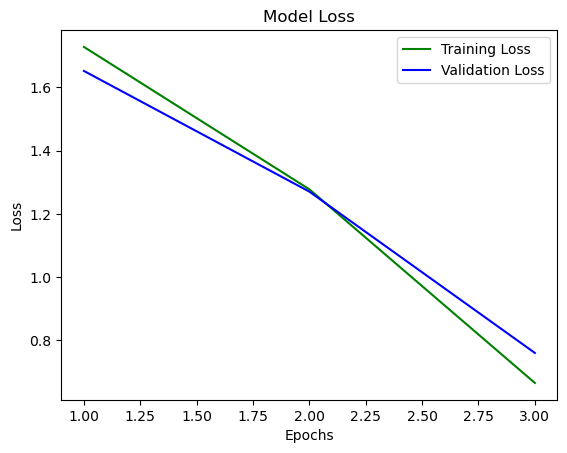

In [22]:
import matplotlib.pyplot as plt

# Assuming you have trained the model and stored the training history in `history` variable

# Get the training loss values
train_loss = history.history['loss']

# Get the validation loss values
val_loss = history.history['val_loss']

# Plot the training and validation loss
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Model: "tf_roberta_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
roberta (TFRobertaMainLayer) multiple                  124055040 
_________________________________________________________________
classifier (TFRobertaClassif multiple                  595206    
Total params: 124,650,246
Trainable params: 124,650,246
Non-trainable params: 0
_________________________________________________________________


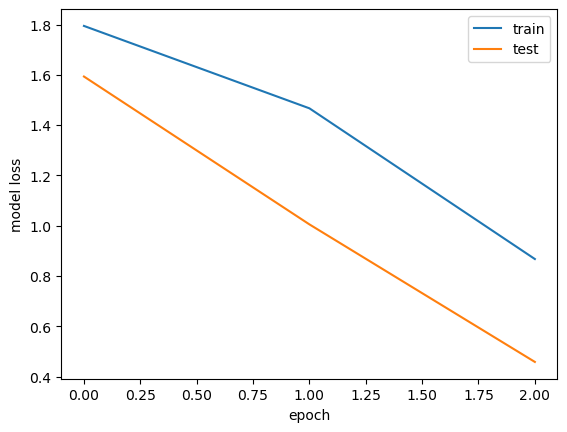

In [22]:
model.summary()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.savefig('train_history.png')
plt.show()